
# Employee clustering based on GAP time

In [49]:

import datetime as dt
import pyodbc
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns 
import statsmodels.formula.api as smf
from sklearn.preprocessing import MinMaxScaler

### We are brining employee start and end clockin anc clockout time along with their first directed and last directed moves. SQL queries were used to bring those data from azure data lake

## Data Preparation

In [3]:

df.dtypes

work_day          datetime64[ns]
wh_id                     object
employee_id                int64
First_Move        datetime64[ns]
Last_Move         datetime64[ns]
employeenumber            object
Clock_In          datetime64[ns]
Clock_out         datetime64[ns]
dtype: object

In [4]:
df['GAP Beginning']=df['First_Move']-df['Clock_In']
df['GAP Beginning']=df['GAP Beginning'].dt.total_seconds()/60
df['GAP Ending']=df['Clock_out']-df['Last_Move']
df['GAP Ending']=df['GAP Ending'].dt.total_seconds()/60

df.head()

,work_day,wh_id,employee_id,First_Move,Last_Move,employeenumber,Clock_In,Clock_out,GAP Beginning,GAP Ending
0,2021-01-10,15,49053,2021-01-10 09:48:00,2021-01-10 14:57:40,049463,2021-01-10 05:00:00,2021-01-10 15:26:41,288.000000,29.016667
1,2021-01-10,1,1006444,2021-01-10 16:26:09,2021-01-11 01:01:05,126678,2021-01-10 16:00:00,2021-01-11 02:23:20,26.150000,82.250000
2,2021-01-10,1,1045358,2021-01-10 05:09:13,2021-01-10 15:19:02,152132,2021-01-10 05:00:00,2021-01-10 15:28:26,9.216667,9.400000
3,2021-01-10,17,1035068,2021-01-10 16:46:08,2021-01-11 02:44:31,147935,2021-01-10 16:30:00,2021-01-11 03:00:00,16.133333,15.483333
4,2021-01-10,1,58113,2021-01-10 14:18:21,2021-01-11 02:19:10,112916,2021-01-10 14:00:00,2021-01-11 02:28:23,18.350000,9.216667


In [52]:
df1=df.groupby(['wh_id','employeenumber'],as_index=False)[['GAP Beginning','GAP Ending']].mean()
df1=df1.rename(columns={'GAP Beginning':'Avg. Beginning GAP','GAP Ending':'Avg. Ending GAP'})
df1=df1[(df1['Avg. Beginning GAP']>=0) & (df1['Avg. Ending GAP']>=0) & (df1['Avg. Beginning GAP']<=500) & (df1['Avg. Ending GAP']<=500)]
scaler=MinMaxScaler()
df1['scale_start']=scaler.fit_transform(df1[['Avg. Beginning GAP']])
df1['scale_end']=scaler.fit_transform(df1[['Avg. Ending GAP']])
x=df1.iloc[:,[4,5]]


In [57]:
df1.head()

,wh_id,employeenumber,Avg. Beginning GAP,Avg. Ending GAP,scale_start,scale_end
0,1,001641,41.285714,3.426190,0.082585,0.006858
1,1,002127,16.753571,76.383333,0.032336,0.152884
2,1,006303,15.085714,53.984524,0.028920,0.108052
3,1,006392,99.268333,29.395000,0.201350,0.058835
4,1,006644,23.919841,10.446667,0.047015,0.020909


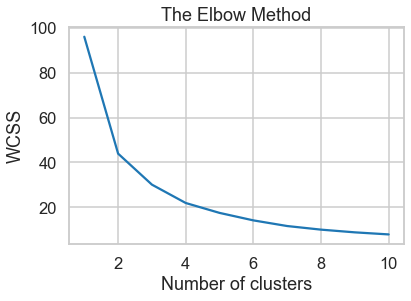

In [65]:
from sklearn.cluster import KMeans
wcss=[]
for i in range(1,11):
    kmeans=KMeans(n_clusters=i, init='k-means++', random_state= 0,max_iter=300,n_init=10)
    kmeans.fit(df1[['scale_start','scale_end']])
    wcss.append(kmeans.inertia_)
    
plt.plot(range(1,11),wcss)
plt.title('The Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

In [66]:
kmeans=KMeans(n_clusters=4, init='k-means++', random_state= 0,max_iter=300,n_init=10)
y=kmeans.fit_predict(df1[['scale_start','scale_end']])
df1['Cluster']=y
df1.head()

,wh_id,employeenumber,Avg. Beginning GAP,Avg. Ending GAP,scale_start,scale_end,Cluster
0,1,001641,41.285714,3.426190,0.082585,0.006858,0
1,1,002127,16.753571,76.383333,0.032336,0.152884,0
2,1,006303,15.085714,53.984524,0.028920,0.108052,0
3,1,006392,99.268333,29.395000,0.201350,0.058835,2
4,1,006644,23.919841,10.446667,0.047015,0.020909,0


array([[0.04369495, 0.04593421],
       [0.22117003, 0.65067727],
       [0.21454116, 0.20345535],
       [0.63558215, 0.25350731]])

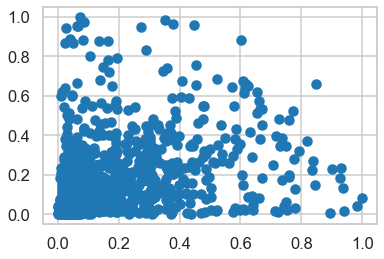

In [75]:
plt.scatter(df1.iloc[:,4],df1.iloc[:,5])
#plt.scatter(kmeans.cluster_centers_[:,0],kmeans.cluster_centers_[:,1],s=300,c='red')
#plt.show()
kmeans.cluster_centers_


In [46]:
y

array([0, 0, 0, ..., 2, 0, 0])

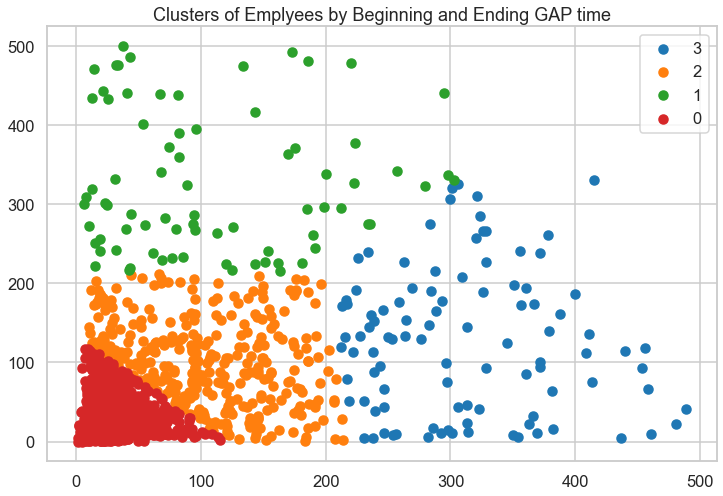

In [80]:
sns.set_style('whitegrid')
sns.set_context('talk')
plt.figure(figsize=(12,8))
plt.title('Clusters of Emplyees by Beginning and Ending GAP time')
#sns.scatterplot(df_final['Avg. Beginning GAP'][df_final['Cluster']==5],df_final['Avg. Ending GAP'][df_final['Cluster']==5],label=5)
#sns.scatterplot(df_final['Avg. Beginning GAP'][df_final['Cluster']==4],df_final['Avg. Ending GAP'][df_final['Cluster']==4],label=4)
plt.scatter(df1['Avg. Beginning GAP'][df1['Cluster']==3],df1['Avg. Ending GAP'][df1['Cluster']==3],label=3)
plt.scatter(df1['Avg. Beginning GAP'][df1['Cluster']==2],df1['Avg. Ending GAP'][df1['Cluster']==2],label=2)
plt.scatter(df1['Avg. Beginning GAP'][df1['Cluster']==1],df1['Avg. Ending GAP'][df1['Cluster']==1],label=1)
plt.scatter(df1['Avg. Beginning GAP'][df1['Cluster']==0],df1['Avg. Ending GAP'][df1['Cluster']==0],label=0)
plt.legend()
plt.show()


In [64]:
df1.to_excel('output.xlsx')